# LSTM Notebook - Volkswagen Passat

Driver Behaviour Classification and Sensor Failure Detection Using Artificial Intelligence and OBD-II<br>
Name: Robert Blee<br>
ID: 18268277<br>
Supervisor: Colin Flanagan<br>
Course Followed: Master of Science in Artificial Intelligence<br>
Year :2019-2020<br>
Department: Computer Science<br>
<br><br>

#### About
This notebook contains code used for LSTM analysis. It contains data processing, model instantiation, model training and testing of numerous files. This covers LSTM for driver behaviour and sensor failure detection for Volkswagen Passat data.  

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from random import seed
from random import randint
import joblib

In [24]:
def plot_test_train(train,test,title):
    """
    Outputs a plot of training/testing data, uses colour difference to shou train/test split in sequential data.

    Inputs:
        train - training data
        test - testing data
        title - plot title
    
    """
    plt.figure(figsize=(12, 10))
    plt.title(title)
    plt.plot(train, label='Training Data')
    plt.plot([None for i in train] + [x for x in test], label='Testing Data')
    plt.legend()
    plt.show()

In [25]:
def multivariate_data(dataset, target, start_index, end_index, history_size,target_size, step, single_step=False):
    """
    Source:  https://www.tensorflow.org/tutorials/structured_data/time_series?hl=da_DK
    Organises data into a format for timeseries processing
    Inputs:
        dataset - feature dataset
        target - target dataset
        start_index - starting index for split
        end_index - end index for split
        history_size - number of previous entries taken into consideration
        target_size - how many instances in future we want to predict (0 for next entry)
        step - step size
        single_step - single step data or not
    Returns:
        numpy array of features
        numpy array of target values
    """
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    
    return np.array(data), np.array(labels)

In [26]:
def plot_train_history(history, title):
    '''
    Plots training and validation losses from model
    Inputs: 
        history - model object for history
        titel - plot title
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [27]:
def plot_reconstruction_loss_hist(X_diff_mean,error_threshold,warning_threshold):
    '''
    Plots reconstruction loss in historgram format
    Inputs:
        X_diff_mean - Array or mean square errors
        error_threshold - Error threshold
        warning_threshold - Warning Threshold
    '''
    plt.figure(figsize=(12, 10))
    plt.hist(X_diff_mean,  bins=20) 
    plt.axvline(x=error_threshold,color='red', linewidth=3, linestyle=':', label="Threshold @%s"%error_threshold)
    plt.axvline(x=warning_threshold,color='orange', linewidth=3, linestyle=':', label="Threshold @%s"%warning_threshold)
    plt.title("Reconstruction Error")
    plt.legend()

In [28]:
def plot_reconstruction_loss(diff,error_threshold,warning_threshold,title):
    '''
    Plots reconstruction loss
    Inputs:
        X_diff_mean - Array or mean square errors
        error_threshold - Error threshold
        warning_threshold - Warning Threshold
        title - plot title
    '''
    plt.figure(figsize=(12, 10))
    plt.plot(diff, 'g', label='MSE')
    plt.title(title)  
    plt.axhline(y=error_threshold,color='red', linewidth=3, linestyle=':', label="Error Threshold @%s"%error_threshold)
    plt.axhline(y=warning_threshold,color='orange', linewidth=3, linestyle=':', label="Warning Threshold @%s"%warning_threshold)
    plt.legend()
    plt.show()

In [29]:
def create_time_steps(length):
    '''
    Source:  https://www.tensorflow.org/tutorials/structured_data/time_series?hl=da_DK
    Creates timeseries steps from a given length Steps lead up to 0.
    Input:
        length - number of steps needed
    
    Returs:
        list of numbers leading up to 0
    '''
    return list(range(-length, 0))

In [30]:
def show_plot(plot_data, delta, title):
    '''
    Source:  https://www.tensorflow.org/tutorials/structured_data/time_series?hl=da_DK
    Plots timeseries data along with actual data and predicted data.
    Inputs:
        plot_data - data to be plotted
        delta - future prediction 
        title - title of plot
    '''
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [31]:
def process_file(model,file,features_considered,scaler,past_history,future_target,STEP,warning_threshold):
    '''
    Reads in a file, processes the data and runs it through the model
    Inputs:
        model - trained model
        file input file
        features_considered - list of features to be used
        scaler - scaler object
        past_history - number of previous entries taken into consideration
        future_target - how many instances in future we want to predict (0 for next entry)
        STEP - step size
        warning_threshold - Threshold used for reference 
    Returns:
        mse - Mean Square Error of data
    '''
    df_tmp = pd.read_csv(file)
    df_tmp.rename(columns={'Engine RPM(rpm)': 'rpm'}, inplace=True)


    features_tmp = df_tmp[features_considered]
    features_tmp.index = df_tmp['GPS Time']

    for col in features_tmp.columns:    
        features_tmp=features_tmp[features_tmp[col] != '-']
        features_tmp[col] = features_tmp[col].astype(float)



    X_df = features_tmp.values

    observations = int(len(X_df))
    print('Observations: %d' % (observations))
    X_df_scaled = scaler.transform(X_df)

   
    X_val, y_val = multivariate_data(X_df_scaled, 
                             X_df_scaled, 
                             0,
                             observations, 
                             past_history,                                             
                             future_target, STEP,                                                 
                             single_step=True)


    val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_data = val_data.batch(1)

    mse=[]
    X_diff = []
    X_pred = []
    for x, y in val_data.take(-1):
        pred = model.predict(x)[0]
        actual = y[0].numpy()
        diff = pred-actual
        diff_mse = np.mean(np.power( diff, 2), axis=0)
        X_pred.append(pred)        

        X_diff.append(diff)        

        mse.append(diff_mse)        
    mse=np.array(mse)
    
    X_diff_mean = mse
    if X_diff_mean.max() > warning_threshold:

        max_diff_row_index = X_diff_mean.argmax()
        max_diff = X_diff[X_diff_mean.argmax()]
        min_val = max_diff.min()
        max_val = max_diff.max()

        if abs(max_val) > abs(min_val):

            faulty_column_index=max_diff.argmax()
        else:
            faulty_column_index=max_diff.argmin()

        actual = X_df_scaled[max_diff_row_index][faulty_column_index]
        predicted = X_pred[max_diff_row_index][faulty_column_index]
        if actual > predicted:
            direction = "Higher"
        else:
            direction = "Lower"
        print("======================================================================")
        print("=======================VALUE EXCEEDED THRESHOLD=======================")        
        print("Sensor: ",features_considered[faulty_column_index])
        print("Recieved value is: ",direction)

    
    return mse



In [32]:
def plot_predictions(model, data, data_len):
    '''
    Run through a number of features, predict the output and plot
    Inputs:
        model - trained model 
        data - data in tensorflow Dataset Format
        data_len - lenght of dataset
    '''
    for x, y in data.take(1):
        for _ in range(10):
            value = randint(0, data_len)
            pred = model.predict(x)[value]
            for feature,title in enumerate(features_considered_sensor):
                plot = show_plot([x[value][:, feature].numpy(), y[value][feature].numpy(),pred[feature]], 0, title)
                plot.show()

In [33]:
def calculate_diff(model,data,data_range):
    '''
    Calculates mean square error
    Inputs: 
        model - trained model 
        data - data in tensorflow Dataset Format
        data_range - lenght of dataset
        
    Returns:
         Mean square error calculcated from predicted and actual values.
    '''
    mse=[]
    for x, y in data.take(1):
        for _ in range(1000):
            value = randint(0, data_range)
            pred = model.predict(x)[value]
            actual = y[value].numpy()
            diff = np.mean(np.power( pred-actual, 2), axis=0)
            mse.append(diff)

    mse=np.array(mse)
    return mse



## Read in data

In [2]:
all_files = glob.glob(os.path.join('data_testing/', "passat_normal_training*.csv")) 
df = pd.concat(map(pd.read_csv, all_files))
df.rename(columns={'Engine RPM(rpm)': 'rpm'}, inplace=True)
df['GPS Time'] = pd.to_datetime(df['GPS Time'])
df.index = df['GPS Time']
df = df.sort_index(axis = 0) 
print(df.head(5))
print(df.tail(5))



C:\Users\lmirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (20,24,25,28,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


                                           GPS Time               Device Time  \
GPS Time                                                                        
2020-07-23 18:49:35-01:00 2020-07-23 18:49:35-01:00  23-Jul-2020 18:49:36.622   
2020-07-23 18:49:36-01:00 2020-07-23 18:49:36-01:00  23-Jul-2020 18:49:37.614   
2020-07-23 18:49:38-01:00 2020-07-23 18:49:38-01:00  23-Jul-2020 18:49:38.616   
2020-07-23 18:49:39-01:00 2020-07-23 18:49:39-01:00  23-Jul-2020 18:49:39.614   
2020-07-23 18:49:40-01:00 2020-07-23 18:49:40-01:00  23-Jul-2020 18:49:40.617   

                           GPS Speed (Meters/second)  \
GPS Time                                               
2020-07-23 18:49:35-01:00                        0.0   
2020-07-23 18:49:36-01:00                        0.0   
2020-07-23 18:49:38-01:00                        0.0   
2020-07-23 18:49:39-01:00                        0.0   
2020-07-23 18:49:40-01:00                        0.0   

                            Horizontal 

## LSTM Sensor failure data preperation

In [43]:
features_considered_sensor = ['Engine Coolant Temperature(°C)',
'Engine Load(%)',
'rpm',
'Intake Air Temperature(°C)',
'Intake Manifold Pressure(psi)',
'Kilometers Per Litre(Instant)(kpl)',
'Mass Air Flow Rate(g/s)',
'Miles Per Gallon(Instant)(mpg)',
'Speed (OBD)(mph)',
'Throttle Position(Manifold)(%)',
'Voltage (OBD Adapter)(V)']
features_sensor = df[features_considered_sensor]
features_sensor.index = df['GPS Time']

for col in features_sensor.columns: 
    features_sensor=features_sensor[features_sensor[col] != '-']
    features_sensor[col] = features_sensor[col].astype(float)

features_sensor.head()

C:\Users\lmirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Engine Coolant Temperature(°C)  Engine Load(%)  \
GPS Time                                                                    
2020-07-23 18:49:38-01:00                            50.0       20.392157   
2020-07-23 18:49:39-01:00                            50.0       31.372549   
2020-07-23 18:49:40-01:00                            50.0       31.372549   
2020-07-23 18:49:40-01:00                            50.0       31.372549   
2020-07-23 18:49:41-01:00                            50.0       31.372549   

                             rpm  Intake Air Temperature(°C)  \
GPS Time                                                       
2020-07-23 18:49:38-01:00  854.0                        23.0   
2020-07-23 18:49:39-01:00  847.0                        23.0   
2020-07-23 18:49:40-01:00  847.0                        23.0   
2020-07-23 18:49:40-01:00  847.0                        23.0   
2020-07-23 18:49:41-01:00  847.0                        23.0   

                           Intake Manifold Pressure(psi)  \
GPS Time                                                   
2020-07-23 18:49:38-01:00                      14.213698   
2020-07-23 18:49:39-01:00                      14.213698   
2020-07-23 18:49:40-01:00                      14.213698   
2020-07-23 18:49:40-01:00                      14.213698   
2020-07-23 18:49:41-01:00                      14.213698   

                           Kilometers Per Litre(Instant)(kpl)  \
GPS Time                                                        
2020-07-23 18:49:38-01:00                                 0.0   
2020-07-23 18:49:39-01:00                                 0.0   
2020-07-23 18:49:40-01:00                                 0.0   
2020-07-23 18:49:40-01:00                                 0.0   
2020-07-23 18:49:41-01:00                                 0.0   

                           Mass Air Flow Rate(g/s)  \
GPS Time                                             
2020-07-23 18:49:38-01:00                      7.4   
2020-07-23 18:49:39-01:00                      7.4   
2020-07-23 18:49:40-01:00                      7.4   
2020-07-23 18:49:40-01:00                      7.4   
2020-07-23 18:49:41-01:00                      7.4   

                           Miles Per Gallon(Instant)(mpg)  Speed (OBD)(mph)  \
GPS Time                                                                      
2020-07-23 18:49:38-01:00                             0.0               0.0   
2020-07-23 18:49:39-01:00                             0.0               0.0   
2020-07-23 18:49:40-01:00                             0.0               0.0   
2020-07-23 18:49:40-01:00                             0.0               0.0   
2020-07-23 18:49:41-01:00                             0.0               0.0   

                           Throttle Position(Manifold)(%)  \
GPS Time                                                    
2020-07-23 18:49:38-01:00                             0.0   
2020-07-23 18:49:39-01:00                             0.0   
2020-07-23 18:49:40-01:00                             0.0   
2020-07-23 18:49:40-01:00                             0.0   
2020-07-23 18:49:41-01:00                             0.0   

                           Voltage (OBD Adapter)(V)  
GPS Time                                             
2020-07-23 18:49:38-01:00                      12.4  
2020-07-23 18:49:39-01:00                      12.4  
2020-07-23 18:49:40-01:00                      12.4  
2020-07-23 18:49:40-01:00                      12.4  
2020-07-23 18:49:41-01:00                      12.4

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018D16E60648>,
      dtype=object)

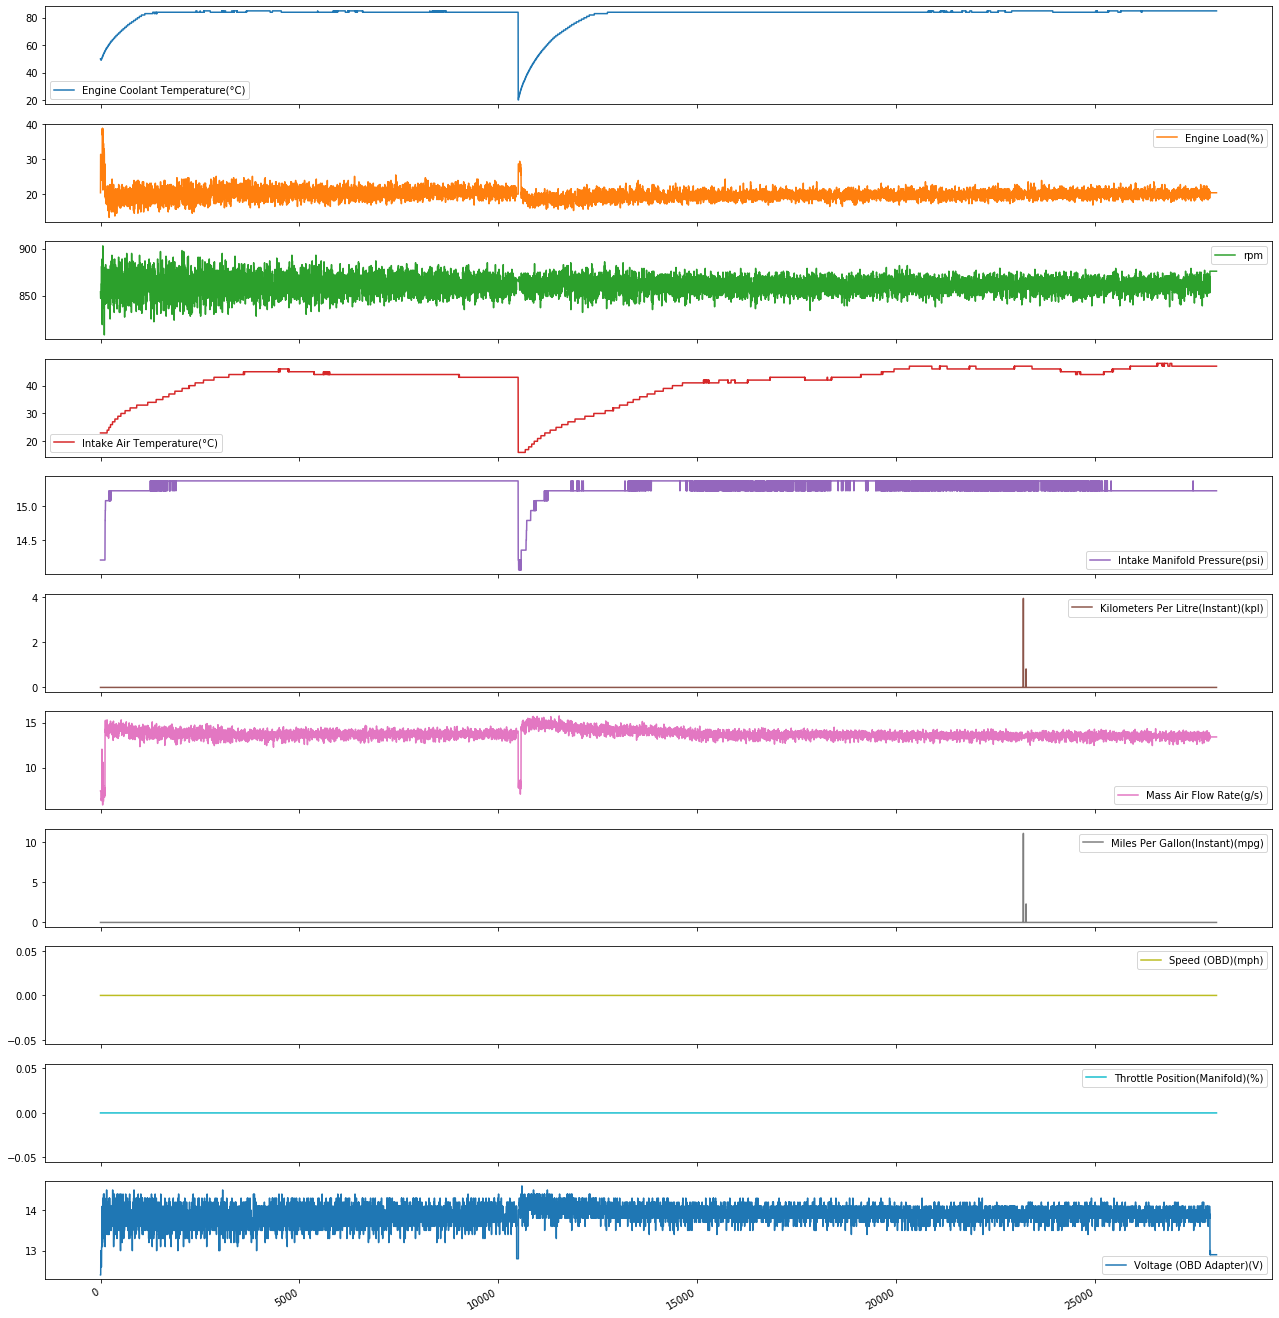

In [68]:
features_sensor.plot(subplots=True,figsize=(22, 26),use_index=False)

In [44]:
X_df_sensor_lstm = features_sensor.values
X_df_sensor_lstm = X_df_sensor_lstm.astype(float)
TRAIN_SPLIT = int(len(X_df_sensor_lstm) * 0.80)
X_df_sensor_lstm_train, X_df_sensor_lstm_test = X_df_sensor_lstm[0:TRAIN_SPLIT], X_df_sensor_lstm[TRAIN_SPLIT:len(X_df_sensor_lstm)]
print('Observations: %d' % (len(X_df_sensor_lstm)))
print('Training Observations: %d' % (len(X_df_sensor_lstm_train)))
print('Testing Observations: %d' % (len(X_df_sensor_lstm_test)))


Observations: 28044
Training Observations: 22435
Testing Observations: 5609


In [45]:
scaler_lstm_sensor = preprocessing.MinMaxScaler()
scaler_lstm_sensor.fit(X_df_sensor_lstm_train)
X_df_sensor_scaled = scaler_lstm_sensor.transform(X_df_sensor_lstm)



In [47]:
past_history = 60 # number of previous entries taken into consideration
future_target = 0 # how many instances in future we want to predict (0 for next entry)
STEP = 1 # step size

x_train_sensor, y_train_sensor = multivariate_data(X_df_sensor_scaled, X_df_sensor_scaled, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_sensor, y_val_sensor = multivariate_data(X_df_sensor_scaled, X_df_sensor_scaled,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [48]:

print('Observations: %d' % (len(X_df_sensor_lstm)))
print('Training Observations: %d' % (len(x_train_sensor)))
print('Testing Observations: %d' % (len(x_val_sensor)))


Observations: 28044
Training Observations: 22375
Testing Observations: 5549


In [49]:
train_data_sensor = tf.data.Dataset.from_tensor_slices((x_train_sensor, y_train_sensor))
train_data_sensor = train_data_sensor.batch(len(x_train_sensor)).repeat()

val_data_sensor = tf.data.Dataset.from_tensor_slices((x_val_sensor, y_val_sensor))
val_data_sensor = val_data_sensor.batch(len(x_val_sensor)).repeat()


In [53]:
print ('Single window of past history : {}'.format(x_train_sensor[0].shape))


Single window of past history : (60, 11)


## LSTM sensor failure model

In [54]:
sensor_model = tf.keras.models.Sequential()
sensor_model.add(tf.keras.layers.LSTM(45,input_shape=x_train_sensor.shape[-2:],return_sequences=True))
sensor_model.add(tf.keras.layers.LSTM(25))
sensor_model.add(tf.keras.layers.Dense(11))
sensor_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
sensor_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 45)            10260     
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                7100      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                286       
Total params: 17,646
Trainable params: 17,646
Non-trainable params: 0
_________________________________________________________________


## Training

In [55]:
steps_per_epoch=1
validation_steps=1

epochs = 100
sensor_history = sensor_model.fit(train_data_sensor, epochs=epochs,
                                            steps_per_epoch=steps_per_epoch,
                                            validation_steps=validation_steps,
                                            validation_data=val_data_sensor)

Train for 1 steps, validate for 1 steps
Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 0.3722 - val_loss: 0.3769
Epoch 2/100
1/1 [==============================] - 8s 8s/step - loss: 0.3397 - val_loss: 0.3453
Epoch 3/100
1/1 [==============================] - 8s 8s/step - loss: 0.3106 - val_loss: 0.3165
Epoch 4/100
1/1 [==============================] - 8s 8s/step - loss: 0.2841 - val_loss: 0.2896
Epoch 5/100
1/1 [==============================] - 9s 9s/step - loss: 0.2595 - val_loss: 0.2637
Epoch 6/100
1/1 [==============================] - 9s 9s/step - loss: 0.2360 - val_loss: 0.2382
Epoch 7/100
1/1 [==============================] - 9s 9s/step - loss: 0.2130 - val_loss: 0.2132
Epoch 8/100
1/1 [==============================] - 9s 9s/step - loss: 0.1905 - val_loss: 0.1888
Epoch 9/100
1/1 [==============================] - 9s 9s/step - loss: 0.1687 - val_loss: 0.1658
Epoch 10/100
1/1 [==============================] - 8s 8s/step - loss: 0.1482 - val_loss: 0.14

Epoch 85/100
1/1 [==============================] - 9s 9s/step - loss: 0.0041 - val_loss: 0.0151
Epoch 86/100
1/1 [==============================] - 10s 10s/step - loss: 0.0041 - val_loss: 0.0151
Epoch 87/100
1/1 [==============================] - 10s 10s/step - loss: 0.0041 - val_loss: 0.0151
Epoch 88/100
1/1 [==============================] - 11s 11s/step - loss: 0.0040 - val_loss: 0.0151
Epoch 89/100
1/1 [==============================] - 10s 10s/step - loss: 0.0040 - val_loss: 0.0151
Epoch 90/100
1/1 [==============================] - 10s 10s/step - loss: 0.0040 - val_loss: 0.0151
Epoch 91/100
1/1 [==============================] - 9s 9s/step - loss: 0.0039 - val_loss: 0.0151
Epoch 92/100
1/1 [==============================] - 9s 9s/step - loss: 0.0039 - val_loss: 0.0151
Epoch 93/100
1/1 [==============================] - 9s 9s/step - loss: 0.0039 - val_loss: 0.0151
Epoch 94/100
1/1 [==============================] - 9s 9s/step - loss: 0.0038 - val_loss: 0.0151
Epoch 95/100
1/1 [==

## Plot sensor training and validation loss


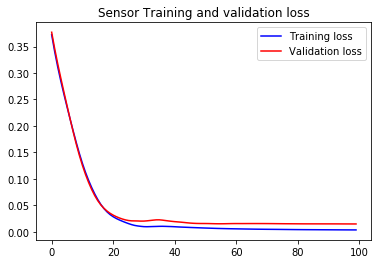

In [56]:
plot_train_history(sensor_history,'Sensor Training and validation loss')

## Plot future predictions

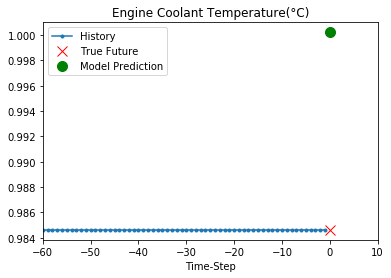

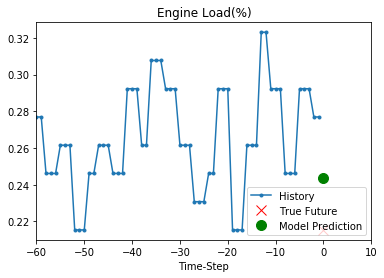

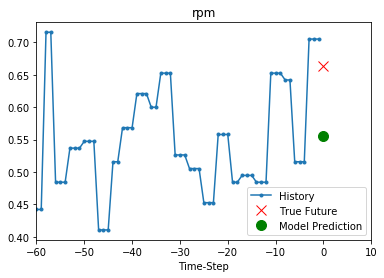

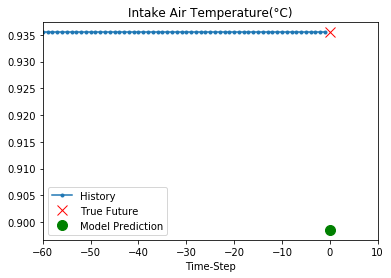

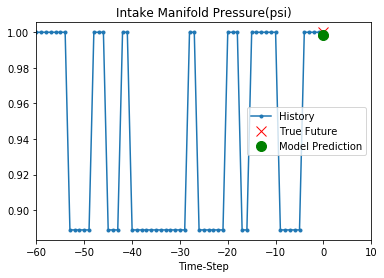

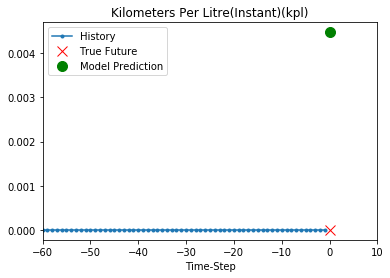

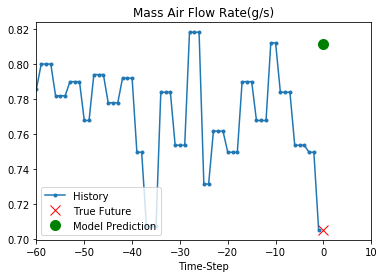

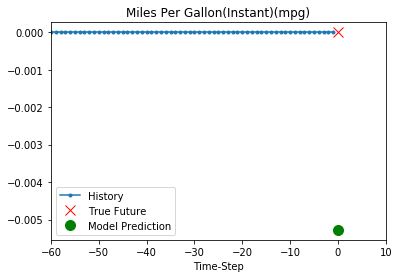

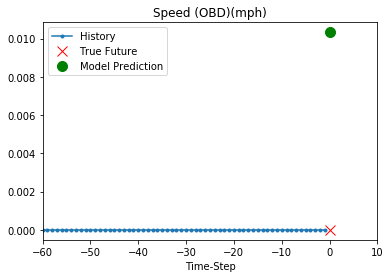

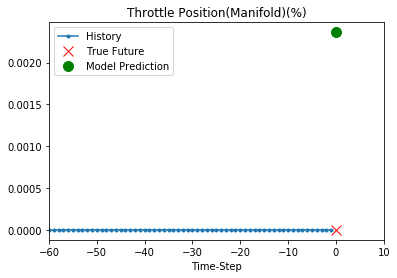

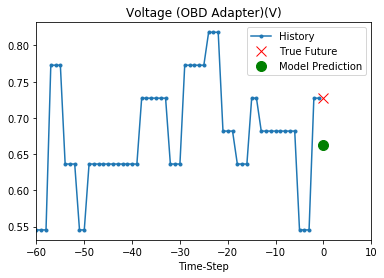

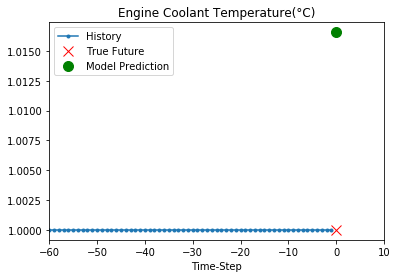

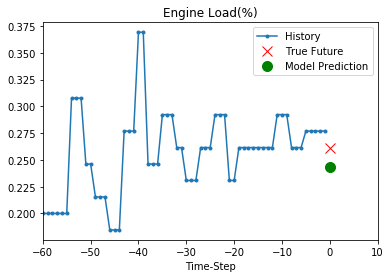

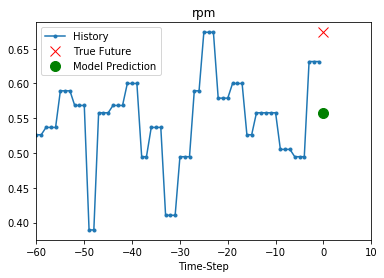

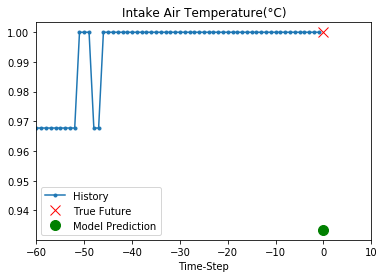

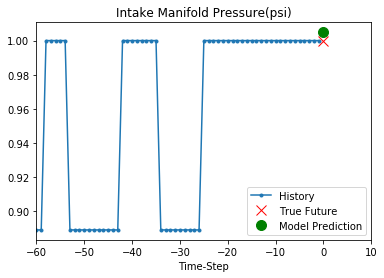

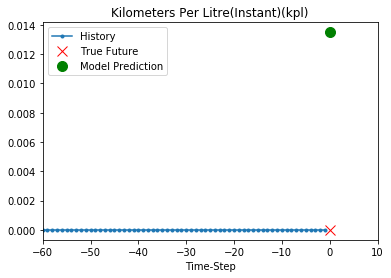

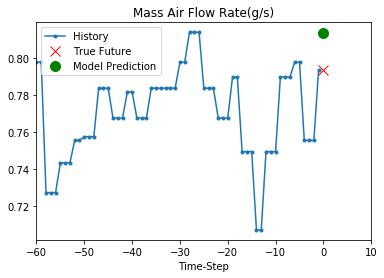

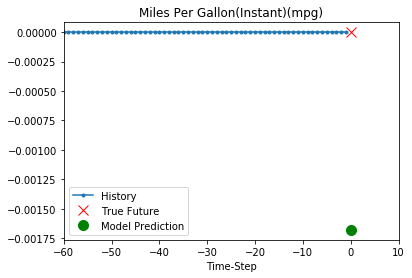

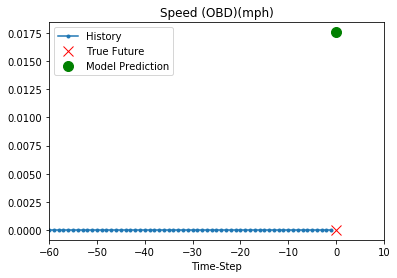

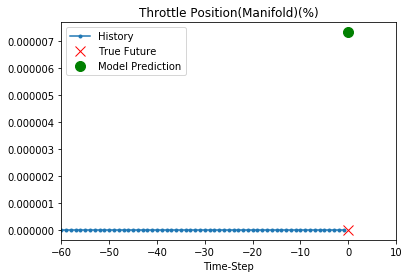

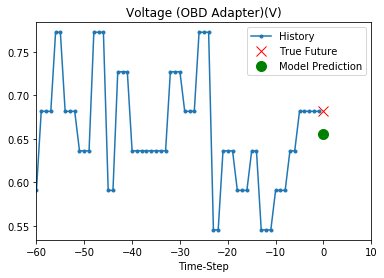

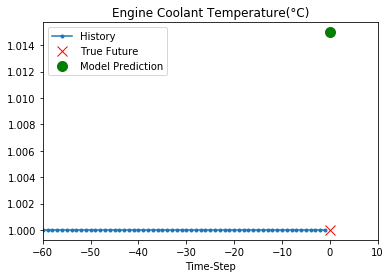

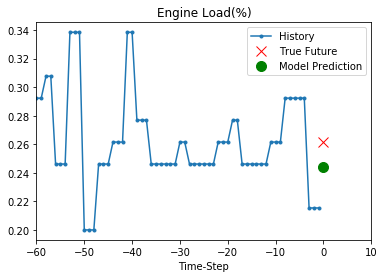

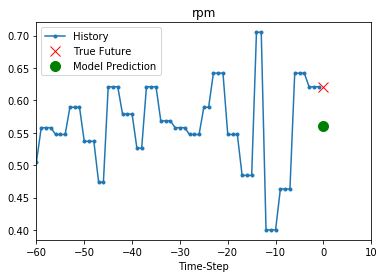

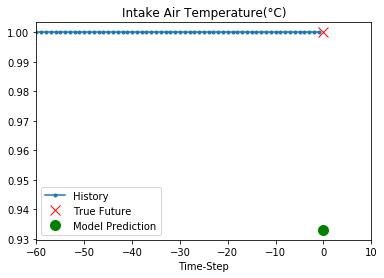

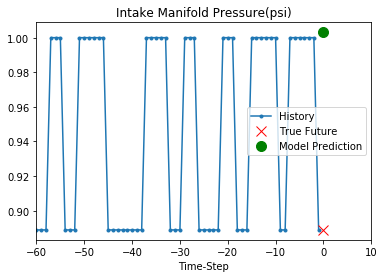

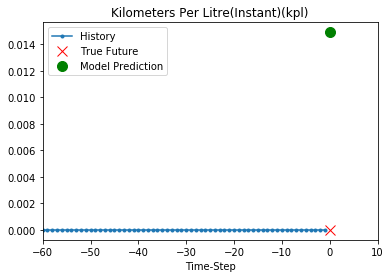

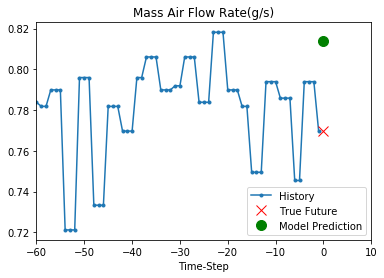

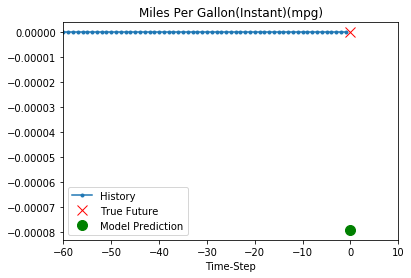

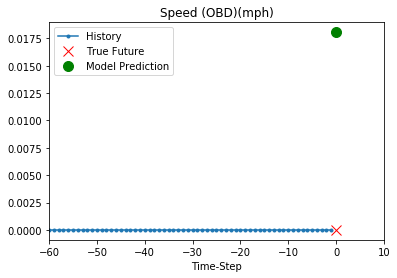

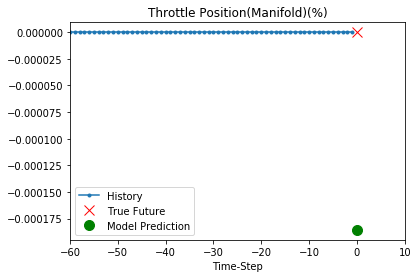

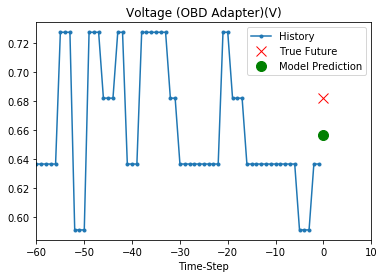

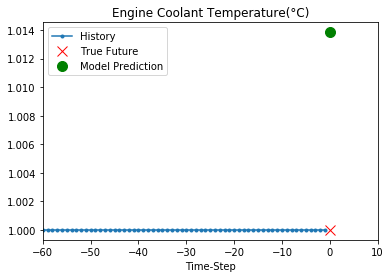

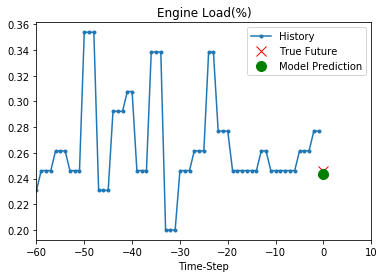

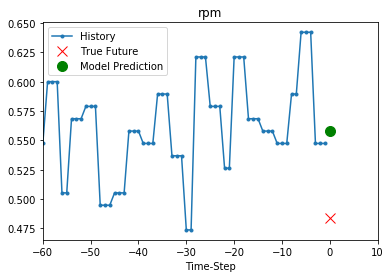

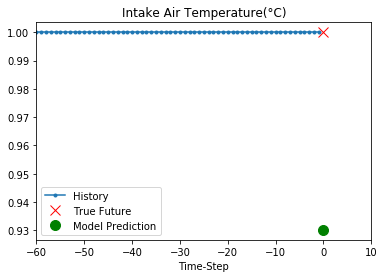

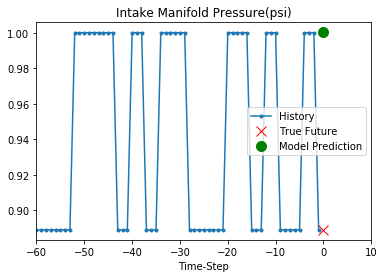

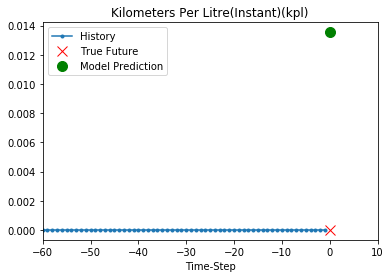

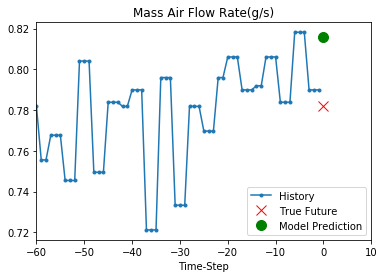

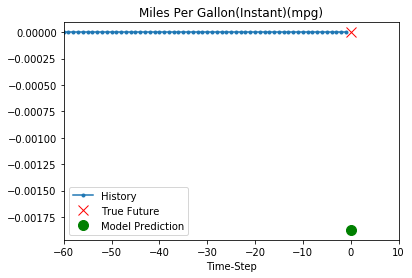

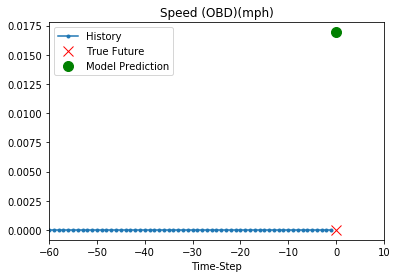

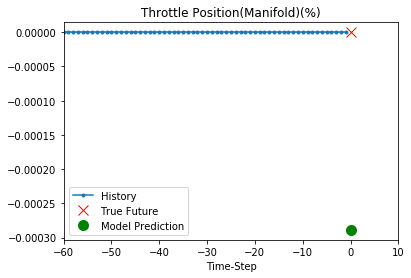

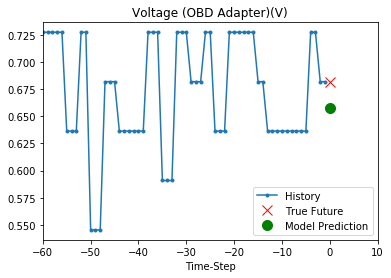

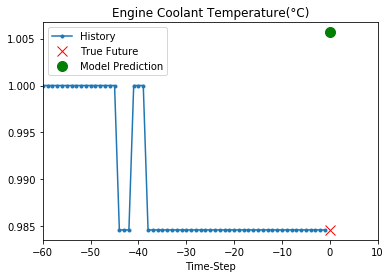

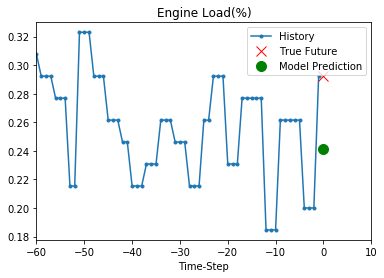

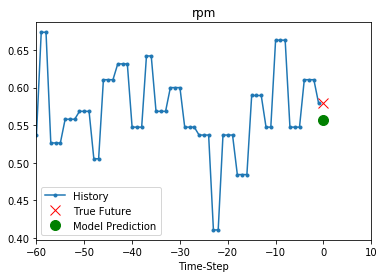

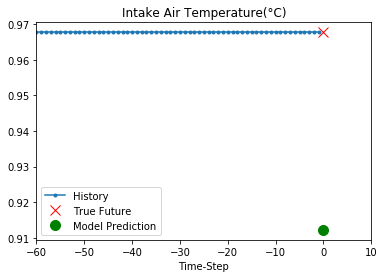

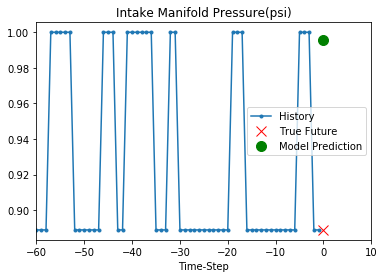

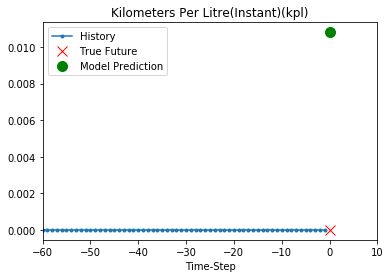

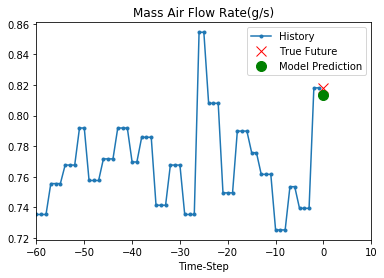

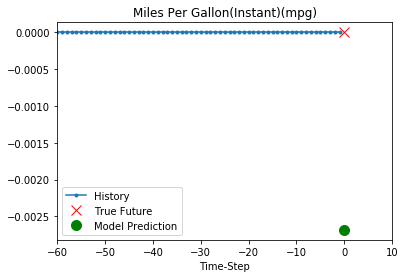

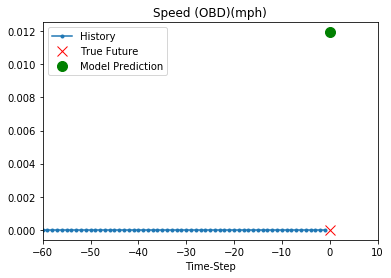

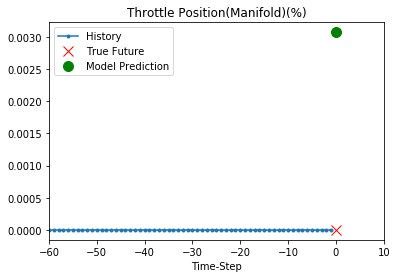

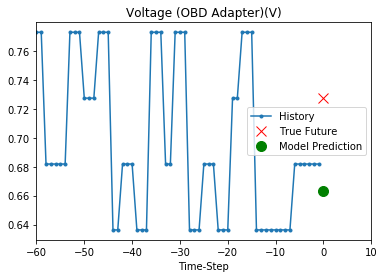

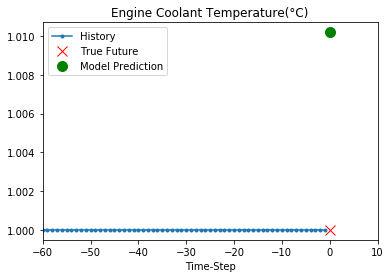

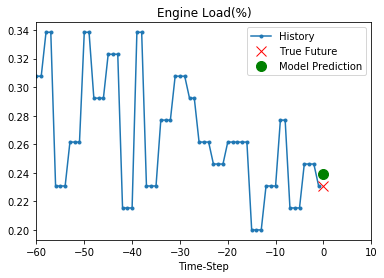

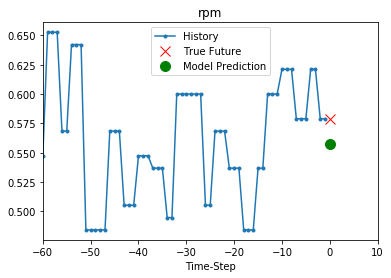

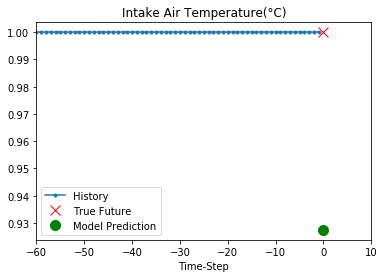

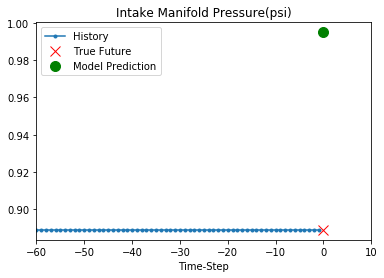

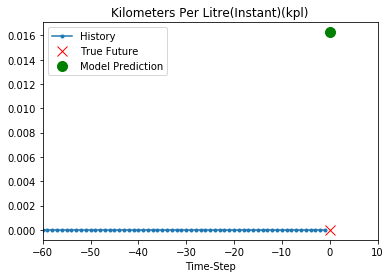

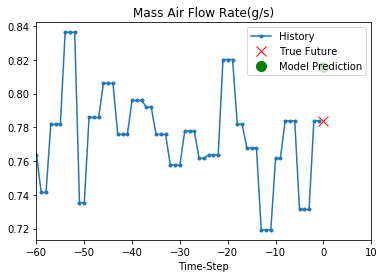

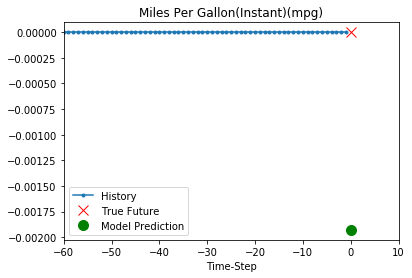

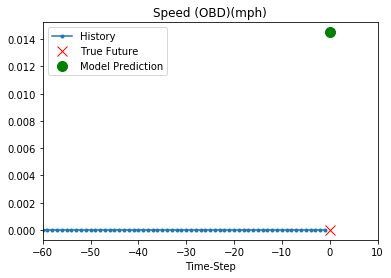

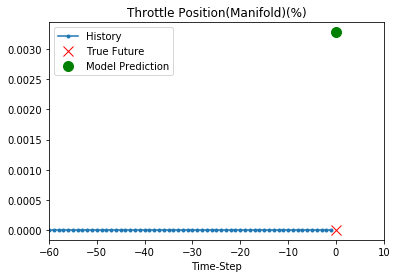

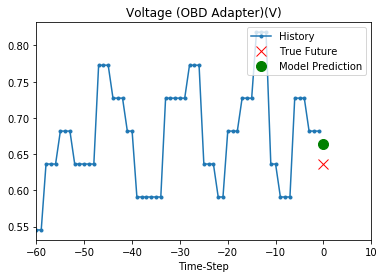

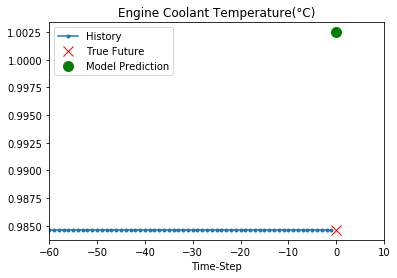

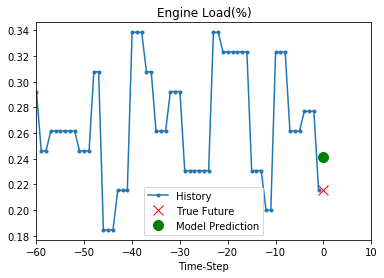

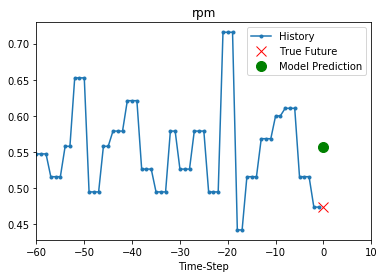

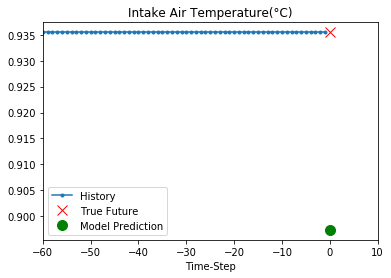

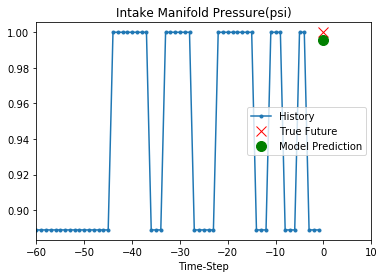

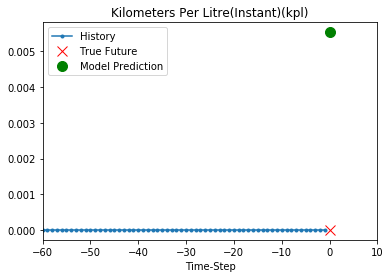

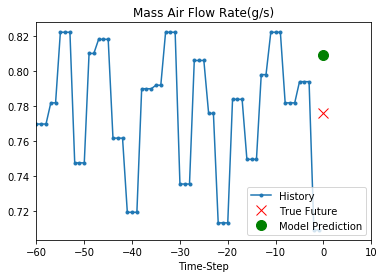

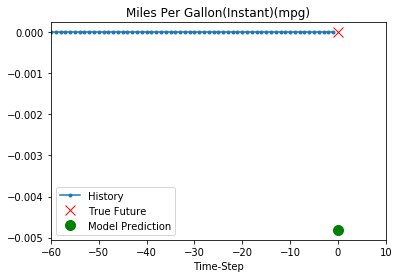

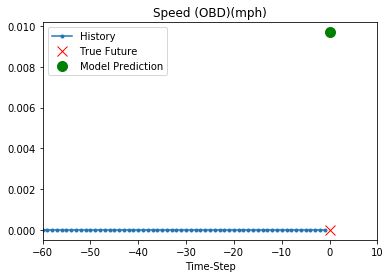

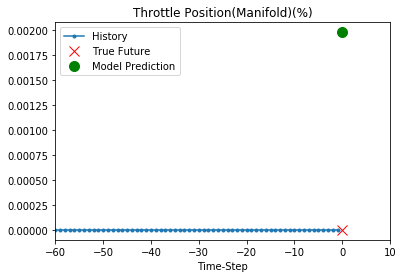

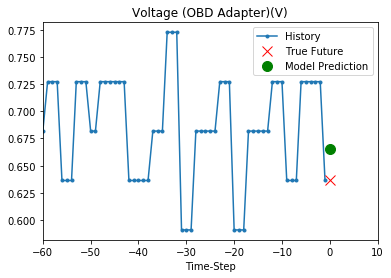

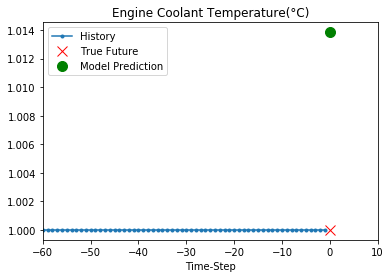

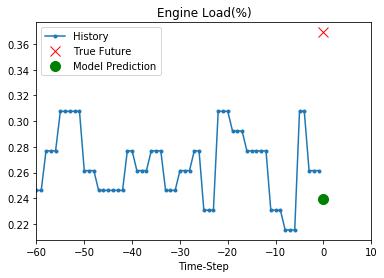

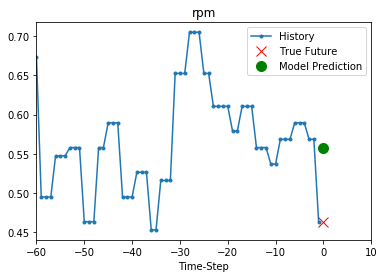

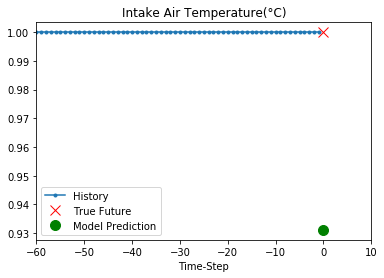

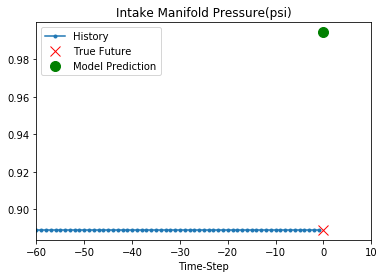

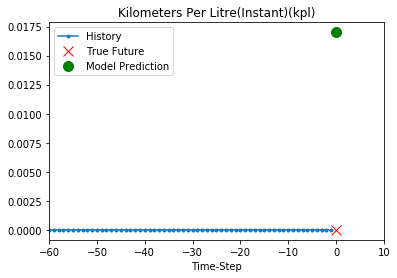

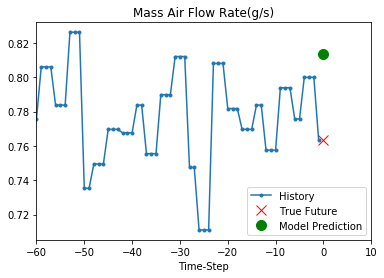

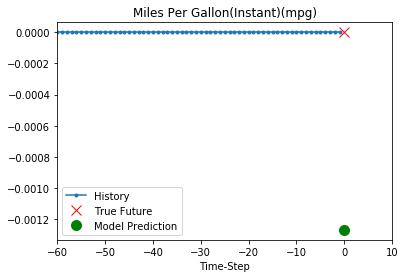

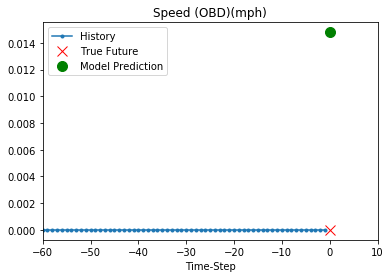

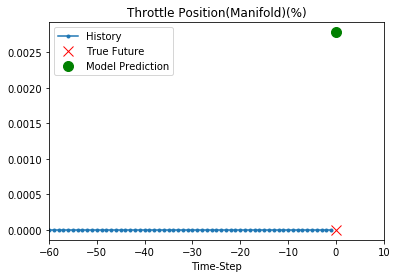

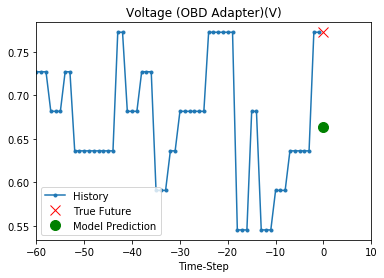

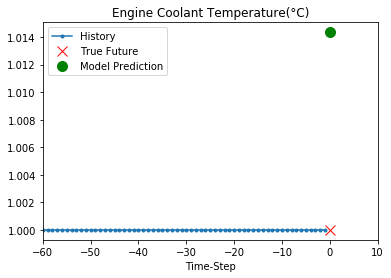

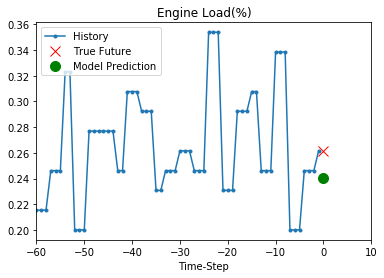

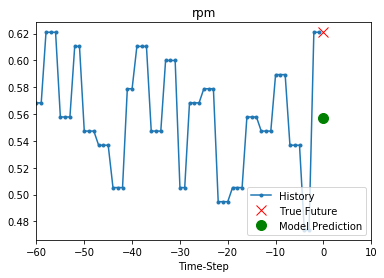

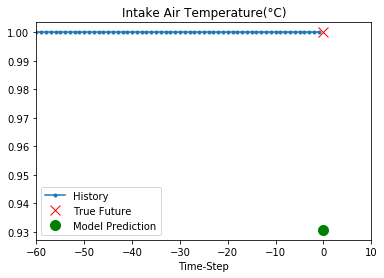

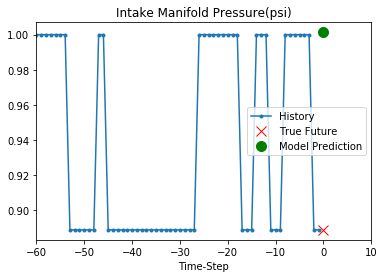

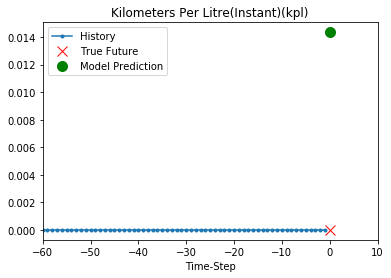

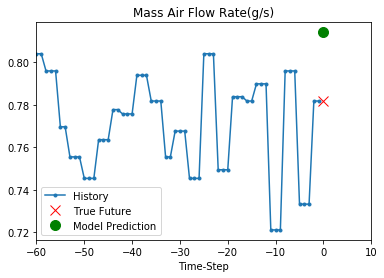

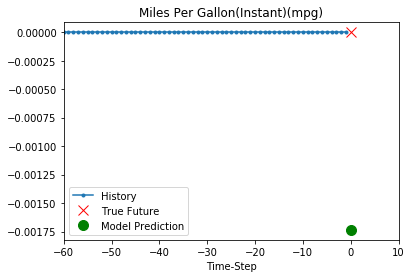

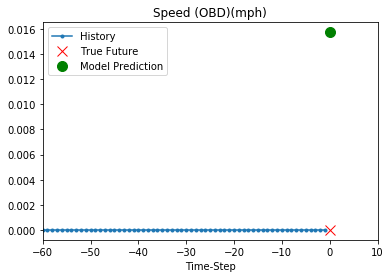

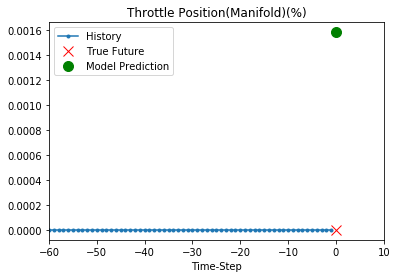

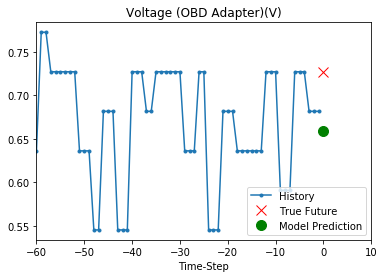

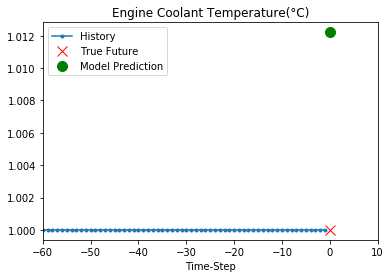

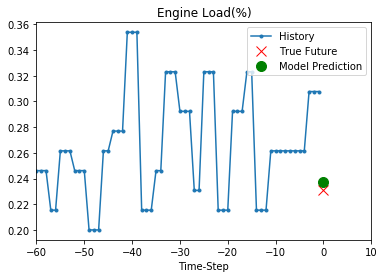

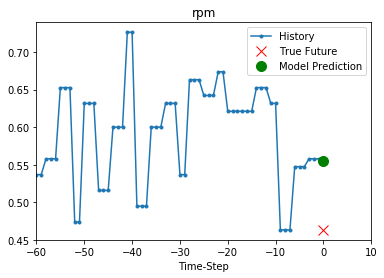

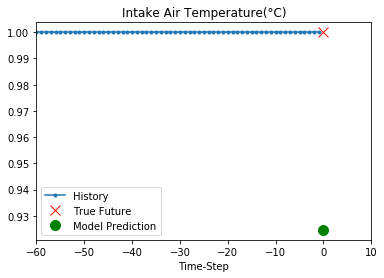

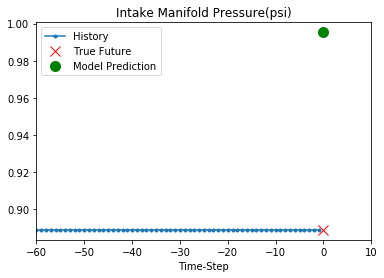

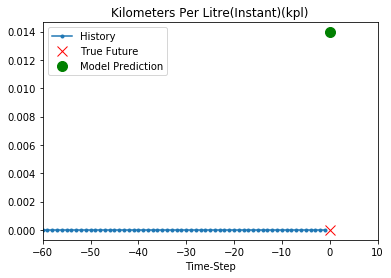

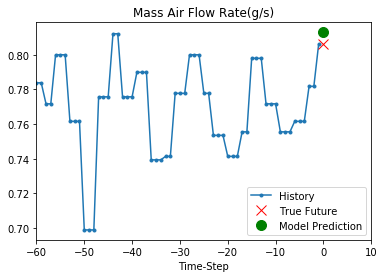

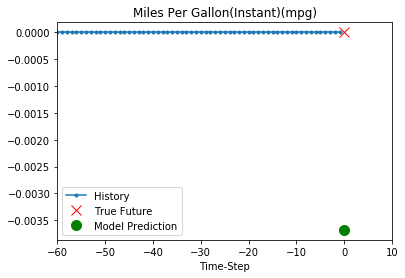

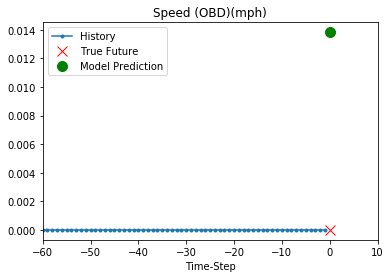

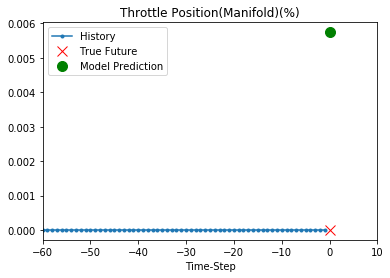

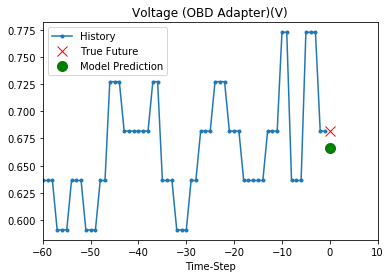

In [58]:
plot_predictions(sensor_model, val_data_sensor, len(x_val_sensor))

In [59]:
sensor_mse=calculate_diff(sensor_model,train_data_sensor,len(x_train_sensor))

0.10234982617626409


## Calculate thresholds


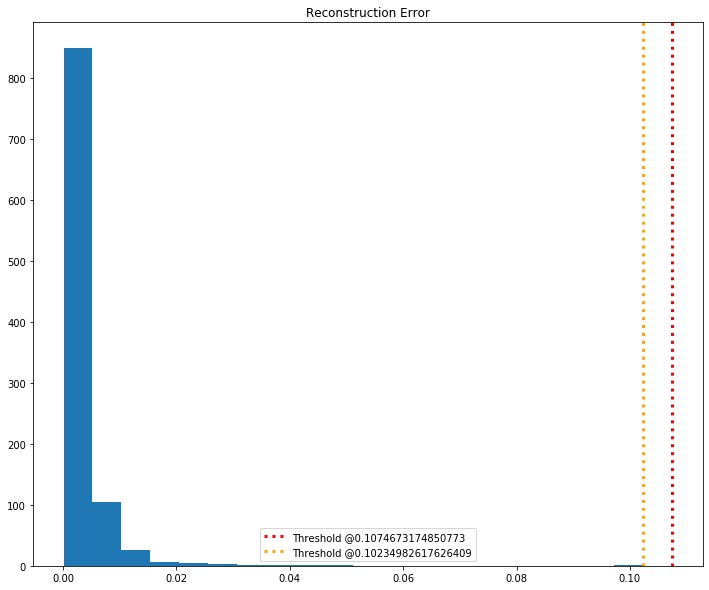

In [61]:
sensor_error_threshold=sensor_mse.max()*1.05
sensor_warning_threshold=sensor_mse.max()
plot_reconstruction_loss_hist(sensor_mse,sensor_error_threshold,sensor_warning_threshold)

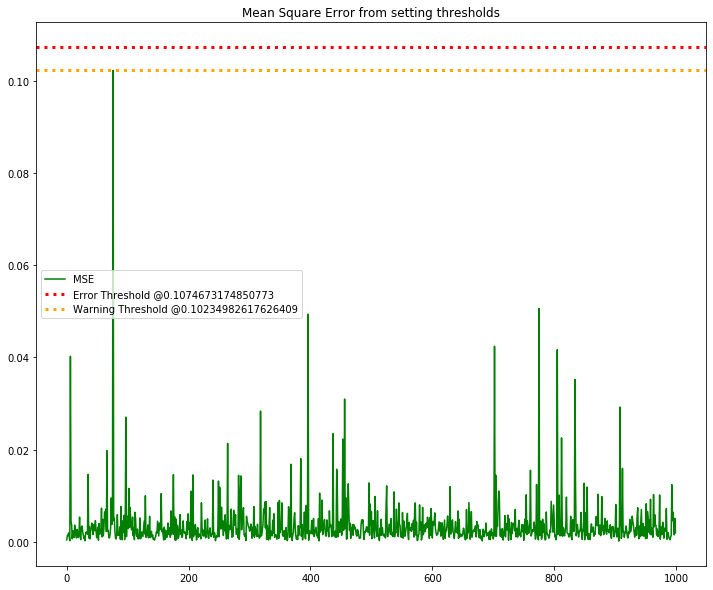

In [62]:
plot_reconstruction_loss(sensor_mse,sensor_error_threshold,sensor_warning_threshold,'Mean Square Error from setting thresholds')

## Process files
### - Normal data
### - Failing MAF
### - Faulty MAF

C:\Users\lmirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Observations: 422


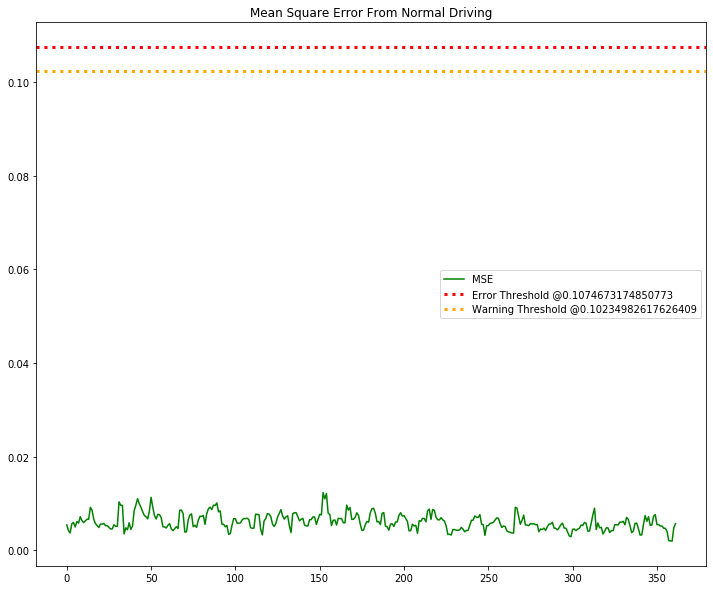

In [110]:
sensor_mse_normal = process_file(sensor_model,"data_testing/passat_normal_test_unseen_data.csv",features_considered_sensor,scaler_lstm_sensor,past_history,future_target,STEP,sensor_error_threshold)
plot_reconstruction_loss(sensor_mse_normal,sensor_error_threshold,sensor_warning_threshold,'Mean Square Error From Normal Driving')

Observations: 279
=======================VALUE EXCEEDED THRESHOLD=======================
Sensor:  Mass Air Flow Rate(g/s)
Recieved value is:  Lower


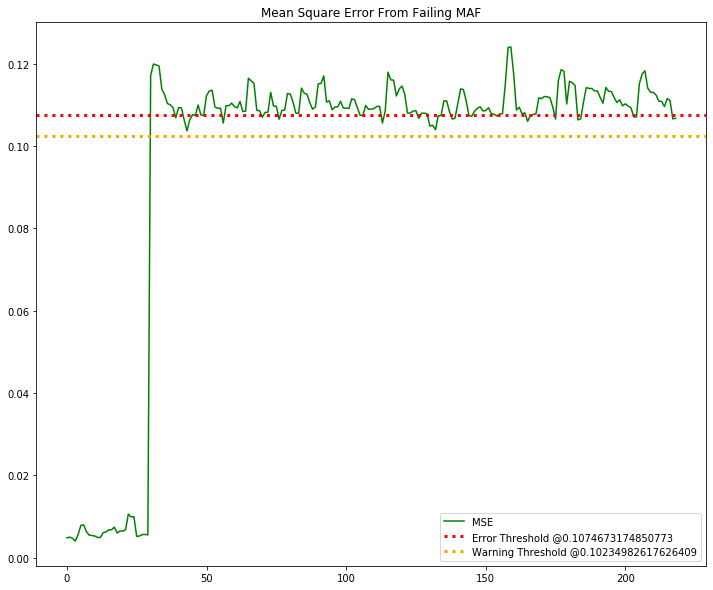

In [117]:
sensor_mse_maf = process_file(sensor_model,"data_testing/passat_failing_maf.csv",features_considered_sensor,scaler_lstm_sensor,past_history,future_target,STEP,sensor_error_threshold)
plot_reconstruction_loss(sensor_mse_maf,sensor_error_threshold,sensor_warning_threshold,'Mean Square Error From Failing MAF')

Observations: 437
=======================VALUE EXCEEDED THRESHOLD=======================
Sensor:  Mass Air Flow Rate(g/s)
Recieved value is:  Higher


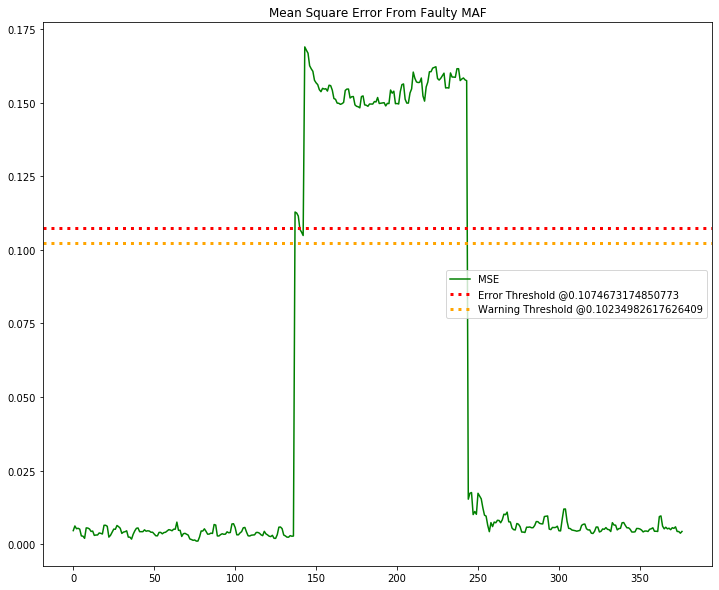

In [118]:
sensor_mse_maf = process_file(sensor_model,"data_testing/passat_faulty_maf.csv",features_considered_sensor,scaler_lstm_sensor,past_history,future_target,STEP,sensor_error_threshold)
plot_reconstruction_loss(sensor_mse_maf,sensor_error_threshold,sensor_warning_threshold,'Mean Square Error From Faulty MAF')